<a href="https://colab.research.google.com/github/talhaanwarch/Sarcasm-nlp/blob/master/multi_input_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
from tensorflow.keras.callbacks import Callback
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [2]:
!pip install keras-tcn
!pip install tensorflow==2.1.0


In [3]:
cd /content/drive/My\ Drive/dataset/sarcasm

/content/drive/My Drive/dataset/sarcasm


In [4]:
ls

model_gru.png
__pycache__/
sarcasm_detection_shared_task_reddit_testing.jsonl
sarcasm_detection_shared_task_reddit_training.jsonl
sarcasm_detection_shared_task_twitter_testing.jsonl
sarcasm_detection_shared_task_twitter_training.jsonl
tokenization.py


In [0]:
import pandas as pd
import numpy as np

In [0]:
twitter_train=pd.read_json('sarcasm_detection_shared_task_twitter_training.jsonl',lines=True)

In [7]:
twitter_train.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [0]:
twitter_train['response']=twitter_train['response'].str.replace('@USER', "") 
twitter_train['response']=twitter_train['response'].str.replace('\d+', '')
twitter_train['response']=twitter_train['response'].str.lower()
twitter_train['response']=twitter_train['response'].str.replace('[^\w\s]','')


In [9]:
twitter_train.head()

,label,response,context
0,SARCASM,i dont get this obviously you do care or y...,[A minor child deserves privacy and should be ...
1,SARCASM,trying to protest about talking about him a...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,he makes an insane about of money from the ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,meanwhile trump wont even release his sat sc...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,pretty sure the antilincoln crowd claimed th...,[Man ... y ’ all gone “ both sides ” the apoca...


In [0]:
twitter_train['context']=twitter_train['context'].apply(lambda x: ','.join(map(str, x)))
twitter_train['context']=twitter_train['context'].str.replace('@USER', "") 
twitter_train['context']=twitter_train['context'].str.lower()
twitter_train['context']=twitter_train['context'].str.replace('[^\w\s]','')
twitter_train['context']=twitter_train['context'].str.replace('\d+', '')


In [11]:
twitter_train.head()

,label,response,context
0,SARCASM,i dont get this obviously you do care or y...,a minor child deserves privacy and should be k...
1,SARCASM,trying to protest about talking about him a...,why is he a loser hes just a press secretar...
2,SARCASM,he makes an insane about of money from the ...,donald j trump is guilty as charged the evid...
3,SARCASM,meanwhile trump wont even release his sat sc...,jamie raskin tanked doug collins collins look...
4,SARCASM,pretty sure the antilincoln crowd claimed th...,man y all gone both sides the apocalypse o...


In [12]:
twitter_test=pd.read_json('sarcasm_detection_shared_task_twitter_testing.jsonl',lines=True)
twitter_test.head()

,context,response,id
0,"[Well now that ’ s problematic AF <URL>, @USER...","@USER @USER @USER My 3 year old , that just fi...",twitter_1
1,[Last week the Fake News said that a section o...,@USER @USER How many verifiable lies has he to...,twitter_2
2,[@USER Let ’ s Aplaud Brett When he deserves i...,@USER @USER @USER Maybe Docs just a scrub of a...,twitter_3
3,[Women generally hate this president . What's ...,@USER @USER is just a cover up for the real ha...,twitter_4
4,"[Dear media Remoaners , you excitedly sharing ...",@USER @USER @USER The irony being that he even...,twitter_5


In [0]:
twitter_test['response']=twitter_test['response'].str.replace('@USER', "") 
twitter_test['response']=twitter_test['response'].str.replace('\d+', '')
twitter_test['response']=twitter_test['response'].str.lower()
twitter_test['response']=twitter_test['response'].str.replace('[^\w\s]','')
twitter_test['context']=twitter_test['context'].apply(lambda x: ','.join(map(str, x)))
twitter_test['context']=twitter_test['context'].str.replace('@USER', "") 
twitter_test['context']=twitter_test['context'].str.lower()
twitter_test['context']=twitter_test['context'].str.replace('[^\w\s]','')
twitter_test['context']=twitter_test['context'].str.replace('\d+', '')


In [14]:
len(twitter_train)

5000

In [15]:
from collections import Counter
Counter(twitter_train['label'])

Counter({'NOT_SARCASM': 2500, 'SARCASM': 2500})

In [0]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_label=le.fit_transform(twitter_train['label'])

#Tokenization

In [0]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 10000 #frequency of words to be kept
max_len = 150

tokenize = Tokenizer(num_words=max_words)
tokenize.fit_on_texts(pd.concat([twitter_train['context'],twitter_train['response']]))
train_sequences_context = tokenize.texts_to_sequences(twitter_train['context'])
train_sequences_response = tokenize.texts_to_sequences(twitter_train['response'])

test_sequences_context = tokenize.texts_to_sequences(twitter_test['context'])
test_sequences_response = tokenize.texts_to_sequences(twitter_test['response'])

word_index = tokenize.word_index


In [0]:
train_sequences_context = sequence.pad_sequences(train_sequences_context,maxlen=max_len,padding='post')
train_sequences_response = sequence.pad_sequences(train_sequences_response,maxlen=max_len,padding='post')

test_sequences_context = sequence.pad_sequences(test_sequences_context,maxlen=max_len,padding='post')
test_sequences_response = sequence.pad_sequences(test_sequences_response,maxlen=max_len,padding='post')

In [19]:

embeddings=np.load('/content/drive/My Drive/dataset/OffenseEval2020/data/English/en_embeddings.npy')
embeddings.shape

(10001, 300)

In [20]:
num_words = min(max_words, len(word_index)) + 1
print(num_words)
embed_size=300

10001


#Model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,concatenate,Dense,Embedding,SpatialDropout1D,Bidirectional,LSTM,GRU,GlobalAveragePooling1D,GlobalMaxPooling1D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [0]:

clr = CyclicLR(base_lr=0.0001, max_lr=0.005,
                        step_size=4., mode='exp_range',
                        gamma=0.99994)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

In [0]:
def model_gru():
  inp1 = Input(shape=(max_len,))
  inp2 = Input(shape=(max_len,))
  x1 = Embedding(num_words,embed_size,embeddings_initializer=Constant(embeddings),input_length=max_len,trainable=False)(inp1)
  x1 = SpatialDropout1D(0.1)(x1)
  x1 = Bidirectional(LSTM(50, return_sequences=True))(x1)
  x1 = Bidirectional(GRU(50, activation= 'tanh',recurrent_activation ='sigmoid',recurrent_dropout=0,
                      unroll =False,use_bias =True,reset_after=True,return_sequences = True))(x1)
  avg_pool1 = GlobalAveragePooling1D()(x1)
  max_pool1 = GlobalMaxPooling1D()(x1)
  conc1 = concatenate([avg_pool1,  max_pool1])
  fc1=Dense(20,activation='tanh')(conc1)


  x2 = Embedding(num_words,embed_size,embeddings_initializer=Constant(embeddings),input_length=max_len,trainable=False)(inp2)
  x2 = SpatialDropout1D(0.1)(x2)
  x2 = Bidirectional(LSTM(50, return_sequences=True))(x2)
  x2 = Bidirectional(GRU(50, activation= 'tanh',recurrent_activation ='sigmoid',recurrent_dropout=0,
                      unroll =False,use_bias =True,reset_after=True,return_sequences = True))(x2)
  avg_pool2 = GlobalAveragePooling1D()(x2)
  max_pool2 = GlobalMaxPooling1D()(x2)
  conc2 = concatenate([avg_pool2,  max_pool2])
  fc2=Dense(20,activation='tanh')(conc2)

  out=concatenate([fc1,fc2])
  drp=Dropout(0.25)(out)
  outfc=Dense(10,activation='tanh')(drp)
  outp = Dense(1, activation="sigmoid")(outfc)    
  model = Model(inputs=[inp1,inp2], outputs=outp)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

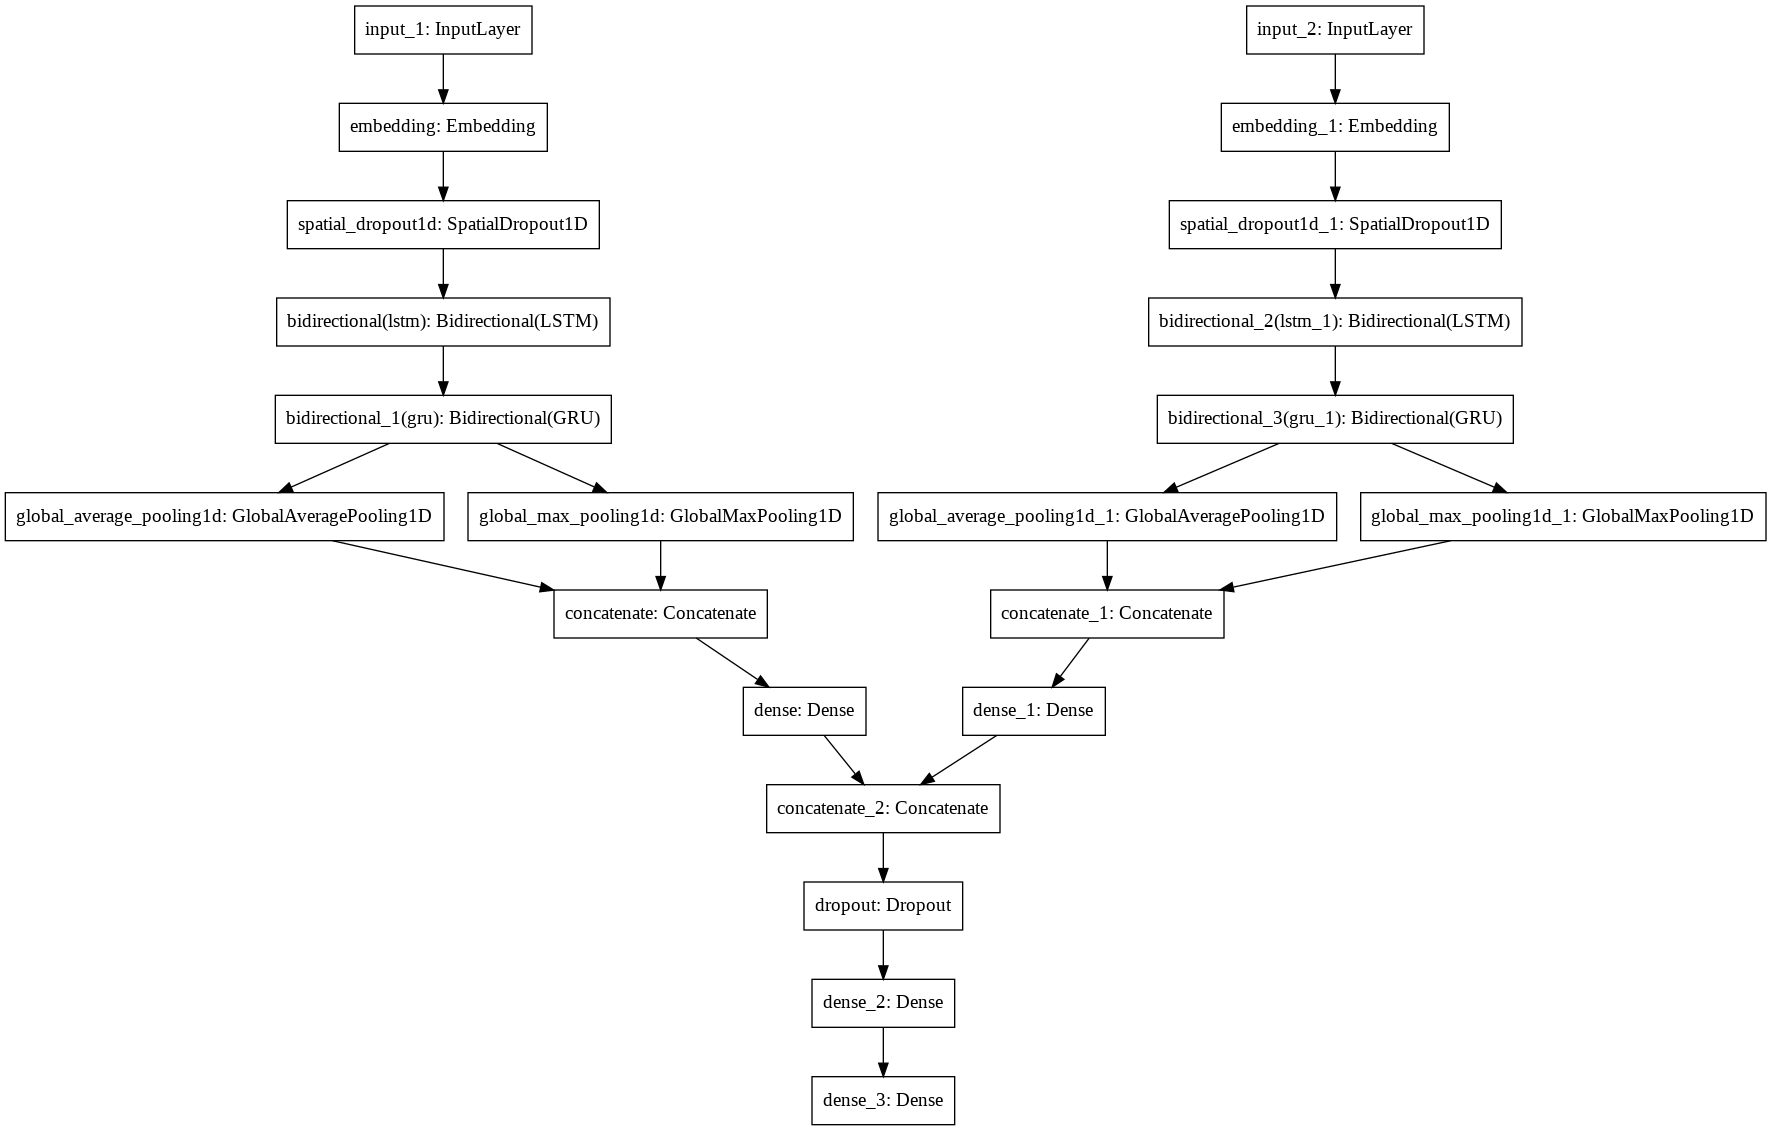

In [28]:
tf.keras.utils.plot_model(model_gru(), to_file='model_gru.png')

In [39]:
kfold = StratifiedKFold(n_splits=5, shuffle=False)
gru_scores = []
gru_test=[]
for train, val in kfold.split(list(zip(train_sequences_context,train_sequences_response)), train_label):
  gru_model=model_gru()
  print(len(train),len(val))
  gru_model.fit([train_sequences_context[train],train_sequences_response[train]],train_label[train],batch_size=64,epochs=10,verbose=2,
            validation_data=([train_sequences_context[val],train_sequences_response[val]], train_label[val]),callbacks=[reduce_lr])
   

  y_pred = gru_model.predict([train_sequences_context[val],train_sequences_response[val]], batch_size=64, verbose=1)

  gru_test.append(gru_model.predict([test_sequences_context,test_sequences_response], batch_size=64, verbose=1).ravel())

  y_pred = (y_pred > 0.5)
  f1=f1_score(train_label[val], y_pred, average='macro')
  gru_scores.append(f1)
  tf.keras.backend.clear_session()

4000 1000
Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 - 31s - loss: 0.6703 - accuracy: 0.5815 - val_loss: 0.6374 - val_accuracy: 0.6500
Epoch 2/10
4000/4000 - 20s - loss: 0.6343 - accuracy: 0.6463 - val_loss: 0.6227 - val_accuracy: 0.6560
Epoch 3/10
4000/4000 - 19s - loss: 0.5843 - accuracy: 0.6955 - val_loss: 0.5918 - val_accuracy: 0.6820
Epoch 4/10
4000/4000 - 19s - loss: 0.5355 - accuracy: 0.7405 - val_loss: 0.5860 - val_accuracy: 0.6980
Epoch 5/10
4000/4000 - 19s - loss: 0.4861 - accuracy: 0.7670 - val_loss: 0.6350 - val_accuracy: 0.6810
Epoch 6/10
4000/4000 - 19s - loss: 0.4093 - accuracy: 0.8238 - val_loss: 0.6288 - val_accuracy: 0.6910
Epoch 7/10
4000/4000 - 19s - loss: 0.3122 - accuracy: 0.8832 - val_loss: 0.6214 - val_accuracy: 0.6840
Epoch 8/10
4000/4000 - 19s - loss: 0.2764 - accuracy: 0.9000 - val_loss: 0.6484 - val_accuracy: 0.6960
Epoch 9/10
4000/4000 - 19s - loss: 0.2397 - accuracy: 0.9218 - val_loss: 0.6430 - val_accuracy: 0.6740
Epoch 10/10
400

In [40]:
np.mean(f1)

0.6318864565310063

In [0]:
gru_test_sub=np.mean(np.array(gru_test),axis=0)
gru_test_sub=gru_test_sub.round()
gru_test_sub=le.inverse_transform(gru_test_sub.ravel().astype('int16'))
gru_test_sub=pd.DataFrame(gru_test_sub,columns=['label'])
gru_test_sub=pd.concat([twitter_test['id'], gru_test_sub], axis=1)
gru_test_sub.head()
gru_test_sub.to_csv('/content/answer.txt',sep=',',index=False,header=None)


#test

In [0]:
y_pred=y_pred.round()

In [0]:
y_pred[0:5]

In [0]:
y_pred=le.inverse_transform(y_pred.ravel().astype('int16'))

In [0]:
y_test=pd.DataFrame(y_pred,columns=['label'])

In [0]:
y_test=pd.concat([twitter_test['id'], y_test], axis=1)

In [0]:
y_test.head()